In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt  
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score
np.random.seed(1)

In [2]:
class fisher(object):
    def _init_(self):
        self.W=None
    def compute_cov_mean(self,x):
        u = np.mean(x, axis=0)
        cov = np.zeros((x.shape[1], x.shape[1]))
        for s in x:
            temp = s - u
            cov+= temp* temp.reshape(2, 1)

        return cov,u
    
    def train(self,x,y):
        num_train,num_features=x.shape
        self.W=np.zeros(num_features+1)
        x_1=x[np.where(y==1)]
        x_2=x[np.where(y==-1)]
        conv1,u1=self.compute_cov_mean(x_1)
        conv2,u2=self.compute_cov_mean(x_2)
        SW=conv1+conv2
        u,s,v=np.linalg.svd(SW)
        sw_inv=np.dot(np.dot(v.T, np.linalg.inv(np.diag(s))), u.T)
        self.W[1:]=np.dot(sw_inv,u1-u2)
        w_conv=self.W[1:]
        y_space1=np.dot(x_1,w_conv)
        uy1=np.mean(y_space1)
        y_space2=np.dot(x_2,w_conv)
        uy2=np.mean(y_space2)
        self.W[0]=-1/2*(uy1+uy2)
        
        
    def linear(self,x):
        return np.dot(x,self.W[1:])+self.W[0]
    
    def predict(self,x):
        return np.where(self.linear(x)>=0.0,1,-1)

In [3]:
class voter(object):
    def _init_(self):
        self.wmatrix=[]
        self.Mode=0
    def train(self,x,y,mode,classifier):
        matrix=[]
        self.Mode=mode
        if mode==0: #ovr
            self.Mode=0
            print('training use ovr vote')
            y=np.array(y)
            n_classes=np.unique(y)
            for i in n_classes:
                y_new=y
                y_new=np.where(y_new==i,1,-1)
                classifier.train(x,y_new)
                matrix.append(classifier.W)
        else:
            if mode==1: #ovo
                self.Mode=1
                print('training use ovo vote')
                n_classes=np.unique(y)
                x=np.array(x)
                y=np.array(y)
                for i in n_classes:
                    for j in n_classes:
                        if(i>=j):
                            continue
                        y_new=y
                        y_new_i=y[np.where(y_new==i)]
                        x_new_i=x[np.where(y_new==i)]
                        y_new_j=y[np.where(y_new==j)]
                        x_new_j=x[np.where(y_new==j)]
                        y_new=np.concatenate((y_new_i,y_new_j),axis=0)
                        x_new=np.concatenate((x_new_i,x_new_j),axis=0)
                        y_new=np.where(y_new==i,1,-1)
                        classifier.train(x_new,y_new)
                        matrix.append(classifier.W)
        self.wmatrix=matrix
        return matrix
    
    def predict(self,x):
        Wm=self.wmatrix
        vote=[]
        tim=0
        result=[]
        if self.Mode==1:
            print('using ovo mode for predicting')
            for i in range(0,len(self.wmatrix)):
                for j in range(0,len(self.wmatrix)):
                    if(i>=j):
                        continue
                    w=Wm[tim]
                    prediction=np.where((np.dot(x,w[1:])+w[0])>=0,i,j)
                    vote.append(prediction)
                    tim+=1
            vote=np.array(vote).T
            for line in vote:
                tt=np.argmax(np.bincount(line))
                result.append(tt)
        else:
            if self.Mode==0:
                print('using ovr mode for predicting')
                for w in self.wmatrix:
                    prediction=np.where((np.dot(x,w[1:])+w[0])>=0,1,-1)
                    vote.append(prediction)
                vote=np.array(vote).T
                for line in vote:
                    tt=np.argmax(line)
                    result.append(tt)
        return np.array(result)

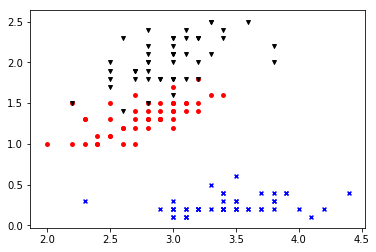

In [4]:
# x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5  
# y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5  
# h = 0.01
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) 
iris=load_iris()
feature=iris.data
target=iris.target
x=feature[:,[1,3]]
y=target[:]
# x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.3, random_state=31,stratify=y)
label = np.array(y)  
index_0 = np.where(label==0)  
plt.scatter(x[index_0,0],x[index_0,1],marker='x',color = 'b',label = '0',s = 15)
index_1 =np.where(label==1)
plt.scatter(x[index_1,0],x[index_1,1],marker='o',color = 'r',label = '1',s = 15) 
index_2=np.where(label==2)
plt.scatter(x[index_2,0],x[index_2,1],marker='v',color = 'k',label = '2',s = 15) 

plt.show()

[-0.09855313  0.01396109  0.03998234]


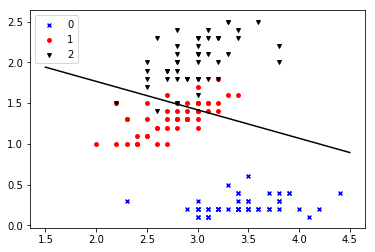

In [5]:
iris=load_iris()
feature=iris.data
target=iris.target
x=feature[:,[1,3]]
y=target[:]
label = np.array(y)  
index_0 = np.where(label==0)  
plt.scatter(x[index_0,0],x[index_0,1],marker='x',color = 'b',label = '0',s = 15)
index_1 =np.where(label==1)
plt.scatter(x[index_1,0],x[index_1,1],marker='o',color = 'r',label = '1',s = 15) 
index_2=np.where(label==2)
plt.scatter(x[index_2,0],x[index_2,1],marker='v',color = 'k',label = '2',s = 15) 
y_new=y
y_new=np.where(y_new==2,1,-1)
# y_new[np.where(y_new!=2)]=-1
fen=fisher()
fen.train(x,y_new)
fen.predict(x)
w=fen.W
print(w)
x1 = np.arange(1.5,5,0.5)  
x2 = -(w[0] +w[1]*x1) / w[2]
plt.plot(x1,x2,color = 'black') 
plt.legend(loc = 'upper left')  
plt.show()

training use ovo vote
using ovo mode for predicting
the accuracy is:  0.9333333333333333


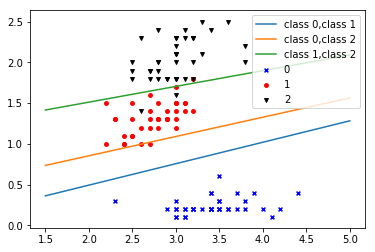

In [6]:
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=31,stratify=y)
label=np.array(y_train)
index_0 = np.where(label==0)  
plt.scatter(x_train[index_0,0],x_train[index_0,1],marker='x',color = 'b',label = '0',s = 15)
index_1 =np.where(label==1)
plt.scatter(x_train[index_1,0],x_train[index_1,1],marker='o',color = 'r',label = '1',s = 15) 
index_2=np.where(label==2)
plt.scatter(x_train[index_2,0],x_train[index_2,1],marker='v',color = 'k',label = '2',s = 15) 

gz=fisher()
vt=voter()
W=vt.train(x_train,y_train,1,gz)
pred=vt.predict(x_test)
acc=accuracy_score(y_test,pred)
print('the accuracy is: ',acc)
k=0
name=['class 0,class 1','class 0,class 2','class 1,class 2']
#show the decision boundary
for w in W:
    x1 = np.arange(1.5,5.5,0.5)  
    x2 = -( w[0] +w[1]*x1) / w[2]  
    plt.plot(x1,x2,label=name[k])   
    plt.legend(loc = 'best')  
    k=k+1
plt.show()  

using ovo mode for predicting


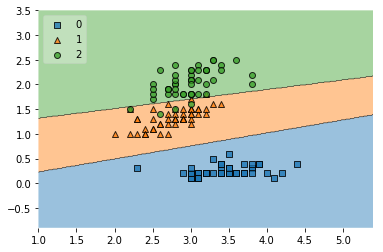

In [7]:
fig = plot_decision_regions(X=x, y=y,
                                clf=vt, legend=2)

training use ovr vote
using ovr mode for predicting
the accuracy is:  0.7533333333333333


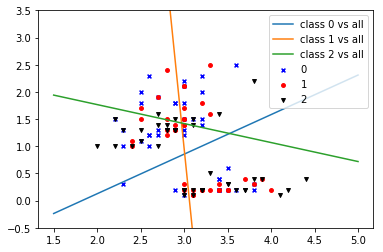

In [8]:
index_0 = np.where(label==0)  
plt.scatter(x[index_0,0],x[index_0,1],marker='x',color = 'b',label = '0',s = 15)
index_1 =np.where(label==1)
plt.scatter(x[index_1,0],x[index_1,1],marker='o',color = 'r',label = '1',s = 15) 
index_2=np.where(label==2)
plt.scatter(x[index_2,0],x[index_2,1],marker='v',color = 'k',label = '2',s = 15) 

gz=fisher()
vt=voter()
W=vt.train(x,y,0,gz)
pred=vt.predict(x)
acc=accuracy_score(y,pred)
print('the accuracy is: ',acc)
k=0
name=['class 0 vs all','class 1 vs all','class 2 vs all']
#show the decision boundary
for w in W:
    x1 = np.arange(1.5,5.5,0.5)  
    x2 = -( w[0] +w[1]*x1) / w[2]  
    plt.ylim(ymax=3.5)
    plt.ylim(ymin=-0.5)
    plt.plot(x1,x2,label=name[k])   
    plt.legend(loc = 'best')  
    k=k+1
plt.show()  

using ovr mode for predicting


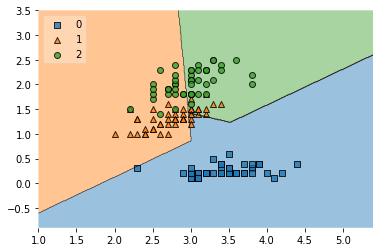

In [9]:
fig = plot_decision_regions(X=x, y=y,
                                clf=vt, legend=2)